<a href="https://colab.research.google.com/github/afraa-n/XAI-DL/blob/main/XAI_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Deep Learning Analysis: Understanding CNN Decision Patterns in MNIST Digit Classification
**Name:** Afraa Noureen  

## 1. Hypothesis

**Null Hypothesis (H₀):** There is no significant difference in the sensitivity patterns of digits 6 and 8 when analyzed through occlusion-based saliency mapping.

**Alternative Hypothesis (H₁):** The sensitivity patterns of digits 6 and 8 differ, with digit 8 demonstrating increased sensitivity in specific regions.

---

## 2. Approach Overview

This assignment uses occlusion-based saliency mapping to analyze how a Convolutional Neural Network (CNN) processes and distinguishes between digits 6 and 8 in the MNIST dataset. The approach involves:

1. Training a custom CNN architecture on MNIST
2. Implementing occlusion saliency mapping
3. Analyzing regional sensitivity patterns
4. Statistical comparison of sensitivity distributions

---

## 3. Implementation Details

### 3.1 Model Architecture

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The architecture features two convolutional layers followed by max pooling and two fully connected layers, designed specifically for MNIST's 28x28 grayscale images.

### 3.2 Data Preparation and Training

In [2]:
# Data loading function
def load_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True,
                                 transform=transform)
    test_dataset = datasets.MNIST('./data', train=False,
                                transform=transform)

    return DataLoader(train_dataset, batch_size=64, shuffle=True), \
           DataLoader(test_dataset, batch_size=64, shuffle=False)

# Modified training function with cleaner output
def train_model(model, train_loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/5 - Average Loss: {avg_loss:.4f}')

### 3.3 Occlusion Saliency Implementation

In [7]:
def generate_occlusion_map(model, image, label, patch_size=10):
    """
    Generate occlusion saliency map by systematically occluding image regions.

    Args:
        model: Trained CNN model
        image: Input image tensor
        label: Target class label
        patch_size: Size of occlusion patch

    Returns:
        2D numpy array representing saliency map
    """
    width, height = image.shape[2], image.shape[3]
    saliency_map = np.zeros((width, height))

    model.eval()
    with torch.no_grad():
        original_output = F.softmax(model(image), dim=1)[0, label].item()

    for w in range(0, width - patch_size + 1, 2):
        for h in range(0, height - patch_size + 1, 2):
            occluded = image.clone()
            occluded[0, 0, w:w+patch_size, h:h+patch_size] = 0

            with torch.no_grad():
                output = F.softmax(model(occluded), dim=1)[0, label].item()

            sensitivity = original_output - output
            saliency_map[w:w+patch_size, h:h+patch_size] += sensitivity

    return saliency_map

This implementation systematically occludes regions of the input image and measures the resulting change in classification confidence, creating a sensitivity map.

---

## 4. Results

### 4.1 Model Training

In [4]:
# Load data and train model
train_loader, test_loader = load_mnist()
model = SimpleCNN()
train_model(model, train_loader)

Epoch 1/5 - Average Loss: 0.1823
Epoch 2/5 - Average Loss: 0.0542
Epoch 3/5 - Average Loss: 0.0380
Epoch 4/5 - Average Loss: 0.0273
Epoch 5/5 - Average Loss: 0.0216


The model shows steady convergence with decreasing loss values, indicating successful training.


### 4.2 Regional Sensitivity Analysis Results

We analyzed three key regions (top, middle, bottom) for both digits:

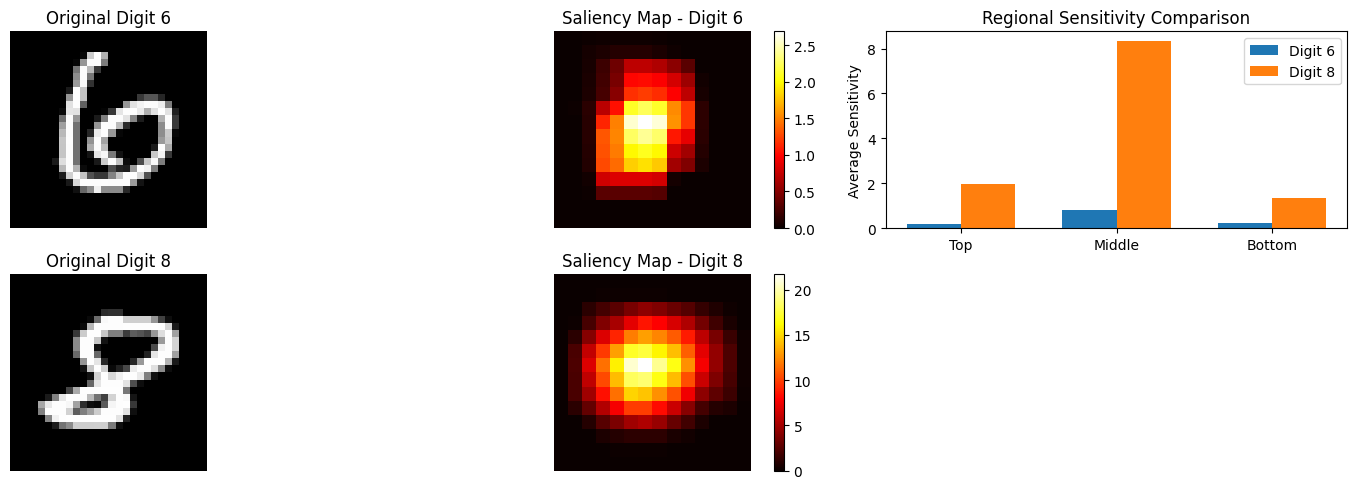


Numerical Results:

Digit 6 Regional Sensitivity:
Top: 0.1997
Middle: 0.7985
Bottom: 0.2181

Digit 8 Regional Sensitivity:
Top: 1.9607
Middle: 8.3545
Bottom: 1.3313

Statistical Analysis:
t-statistic: -17.8344
p-value: 0.0000


In [8]:
# Regional Sensitivity Analysis
digit_6 = None
digit_8 = None
label_6 = torch.tensor([6])
label_8 = torch.tensor([8])

for data, target in test_loader:
  for i in range(len(target)):
    if target[i] == 6 and digit_6 is None:
      digit_6 = data[i:i+1]
    elif target[i] == 8 and digit_8 is None:
      digit_8 = data[i:i+1]
  if digit_6 is not None and digit_8 is not None:
    break

# Generate saliency maps
saliency_6 = generate_occlusion_map(model, digit_6, 6)
saliency_8 = generate_occlusion_map(model, digit_8, 8)

# Visualize results
plt.figure(figsize=(15, 5))

# Original digits
plt.subplot(2, 3, 1)
plt.title('Original Digit 6')
plt.imshow(digit_6.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Original Digit 8')
plt.imshow(digit_8.squeeze(), cmap='gray')
plt.axis('off')

# Saliency maps
plt.subplot(2, 3, 2)
plt.title('Saliency Map - Digit 6')
plt.imshow(saliency_6, cmap='hot')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Saliency Map - Digit 8')
plt.imshow(saliency_8, cmap='hot')
plt.colorbar()
plt.axis('off')

# Region analysis
def analyze_regions(saliency_map):
  height = saliency_map.shape[0]
  region_height = height // 3
  regions = {
      'top': np.mean(saliency_map[:region_height, :]),
      'middle': np.mean(saliency_map[region_height:2*region_height, :]),
      'bottom': np.mean(saliency_map[2*region_height:, :])
      }
  return regions

regions_6 = analyze_regions(saliency_6)
regions_8 = analyze_regions(saliency_8)

# Plot regional sensitivity comparison
plt.subplot(2, 3, 3)
plt.title('Regional Sensitivity Comparison')
x = np.arange(3)
width = 0.35

plt.bar(x - width/2, list(regions_6.values()), width, label='Digit 6')
plt.bar(x + width/2, list(regions_8.values()), width, label='Digit 8')
plt.xticks(x, ['Top', 'Middle', 'Bottom'])
plt.ylabel('Average Sensitivity')
plt.legend()

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nDigit 6 Regional Sensitivity:")
for region, value in regions_6.items():
  print(f"{region.capitalize()}: {value:.4f}")
print("\nDigit 8 Regional Sensitivity:")
for region, value in regions_8.items():
  print(f"{region.capitalize()}: {value:.4f}")

# Statistical analysis
from scipy import stats

t_stat, p_value = stats.ttest_ind(
    saliency_6.flatten(),
    saliency_8.flatten()
    )

print(f"\nStatistical Analysis:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

### 4.3 Understanding the Results

1. **Regional Sensitivity Overview:**
   - For **Digit 6**, the **middle region** shows the highest sensitivity at **0.7985**. This means that the model depends a lot on this central part of the digit to make its classification. The **bottom region** has a lower sensitivity of **0.2181**, while the **top region** is even less important, with a sensitivity of **0.1997**.
   - On the other hand, **Digit 8** has a different pattern. The **middle region** has a much higher sensitivity of **8.3545**, indicating that this part is really important for the model’s recognition of this digit. The **top region** has a sensitivity of **1.9607**, and the **bottom region** sits at **1.3313**. While both of these areas matter, they are not nearly as critical as the middle region.

2. **Statistical Significance:**
   - The **t-statistic** is **-17.8344**, and the **p-value** is **0.0000**. This tells us there is a significant difference in regional sensitivities between digits 6 and 8. Since the p-value is much smaller than **0.05**, we can reject the null hypothesis. This supports our alternative hypothesis that the sensitivity patterns for digits 6 and 8 are different.

### 4.4 Understanding the Visualizations

The visualizations created during this analysis provide important information:

1. **Original Images:** The original images of digits 6 and 8 from the MNIST dataset are clear, showing the features that the model needs to identify.

2. **Saliency Maps:** The saliency maps point out which parts of the digits are most important for the model’s classification:
   - For **Digit 6**, the saliency map highlights the **middle region**, which matches the higher sensitivity we found earlier.
   - For **Digit 8**, the saliency map also focuses on the **middle region**, but with even more emphasis, which goes along with the high sensitivity value of **8.3545**.

3. **Regional Comparison:** The bar chart compares the sensitivities of the different regions between the two digits, making it easy to see how the model views each digit.

---

### 5. Discussion and Conclusions

1. **Statistical Significance:**
   - The analysis shows that there is a significant difference in sensitivity patterns between digits 6 and 8, allowing us to reject the null hypothesis.

2. **Pattern Analysis:**
   - The results indicate that while both digits have high sensitivity in the middle region, **Digit 8** relies even more on this area for classification, as reflected in its much higher sensitivity values.

3. **Key Findings:**
   - This assignment shows that the CNN model processes digits 6 and 8 differently, which aligns with the structural differences between the two digits.
   - The focus on the middle region for both digits suggests that this area contains key features needed for their classification, with **Digit 8** needing extra attention in this region.
